## Training and export Sneaker Wizard Model
Notebook used for training a "sneaker wizard" model using the SageMaker instance.

In [2]:
from fastai.vision import *
import matplotlib.pyplot as plt

In [3]:
# Set path to sneaker classes 
path = Path('dataset/sneakers')

In [4]:
# Create a data from provided dataset of sneakers; group images into bunch VALID, TRAINING
bs = 64
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=299, bs=bs//2, num_workers=4).normalize(imagenet_stats)



In [5]:
# Print out the sneaker classes, number of classes, number of valid images
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['Adidas_Human_Race_NMD_Pharrell_x_Chanel',
  'Air_Fear_of_God_1_Sail_Black',
  'Air_Force_1_Off-White_Volt',
  'Air_Max_1_97_Sean_Weatherspoon',
  'Air_Max_1_Atmos_Animal_Pack',
  'Air_Max_1_Atmos_Elephant',
  'Air_Max_1_Atmos_Supreme_Animal_Pack',
  'Air_Max_90_Infrared',
  'Air_Max_90_Off-White_Black',
  'Air_Max_90_Off-White_Desert_Ore',
  'Air_Max_97_Shanghai_Kaleidoscope',
  'Air_Max_97_Silver_Bullet',
  'Air_Presto_Off-White_Black',
  'Air_Presto_Off-White_Ten',
  'Air_Presto_Off-White_White',
  'Air_Vapormax_Off-White_White',
  'Air_Yeezy_2_Red_October',
  'Air_Zoom_Fly_SP_Off-White_Tulip_Pink',
  'Air_Zoom_Terra_Kiger_5_Off-White_Black',
  'Converse_Chuck_70_Off-White_White',
  'Converse_Comme_Des_Garcons',
  'Jordan_1_Retro_High_Off-White_University_Blue',
  'Jordan_1_Retro_High_Travis_Scott',
  'Jordan_3_Retro_Og_Black_Cement',
  'Jordan_4_Retro_Bred',
  'Jordan_4_Retro_Og_White_Cement',
  'Jordan_6_Retro_Infrared',
  'Nike_LD_Waffle_Sacai_Blue_Multi',
  'Nike_React_Element

In [6]:
# Create convolutional network resnet 101; can specify to something different
learn2 = cnn_learner(data, models.resnet101, metrics=error_rate)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


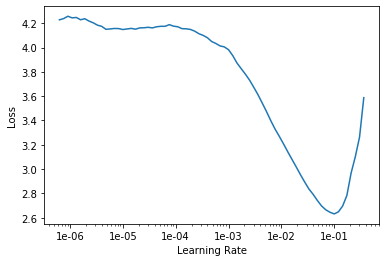

In [6]:
# Determine learning rate and plot it 
learn2.lr_find()
learn2.recorder.plot()

In [7]:
# Begin training cycle, 5 epochs
learn2.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate,time
0,0.708653,0.253529,0.062937,01:45
1,0.231708,0.135322,0.032867,01:44
2,0.129372,0.099967,0.030769,01:43
3,0.064714,0.076873,0.020979,01:44
4,0.034160,0.070734,0.019580,01:44


In [8]:
# Save model
learn2.save('stage-1-101')

In [9]:
# Training cycle 2, 5 epochs
learn2.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate,time
0,0.054097,0.080361,0.024476,01:43
1,0.119989,0.123990,0.034266,01:44
2,0.075750,0.112669,0.028671,01:44
3,0.037309,0.083836,0.024476,01:45
4,0.023118,0.075253,0.020979,01:46


In [10]:
# Save model
learn2.save('stage-2-101')

In [11]:
# Training cycle 3, 8 epochs
learn2.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate,time
0,0.024079,0.076692,0.019580,01:44
1,0.046956,0.083816,0.021678,01:45
2,0.095386,0.103398,0.027273,01:44
3,0.045866,0.097876,0.021678,01:43
4,0.031533,0.084299,0.020280,01:44
5,0.019585,0.084585,0.018881,01:45
6,0.020944,0.081290,0.020979,01:46
7,0.011392,0.076684,0.018182,01:44


In [12]:
learn2.save('stage-3-101')

In [10]:
# Load any of the models; in this case we chose the 3rd iteration cycle
learn2.load('stage-3-101')

Learner(data=ImageDataBunch;

Train: LabelList (5722 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
Air_Max_97_Shanghai_Kaleidoscope,Air_Max_97_Shanghai_Kaleidoscope,Air_Max_97_Shanghai_Kaleidoscope,Air_Max_97_Shanghai_Kaleidoscope,Air_Max_97_Shanghai_Kaleidoscope
Path: dataset/sneakers;

Valid: LabelList (1430 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
Yeezy_Boost_350_V2_Frozen_Yellow,Air_Max_90_Infrared,Jordan_4_Retro_Og_White_Cement,Air_Max_1_Atmos_Animal_Pack,Jordan_6_Retro_Infrared
Path: dataset/sneakers;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1,

In [11]:
# Interpolation matrix
interp = ClassificationInterpretation.from_learner(learn2)

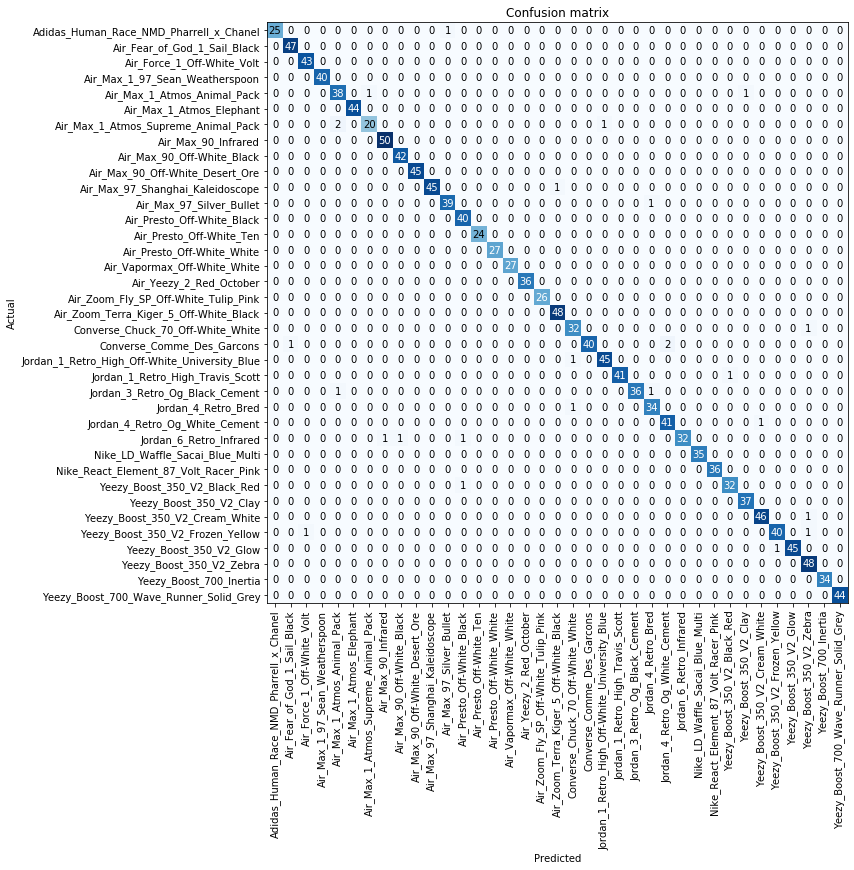

In [12]:
# Confusion matrix; visualize the confusion between sneaker classes; higher values = less confusion
interp.plot_confusion_matrix(figsize=(12,12))

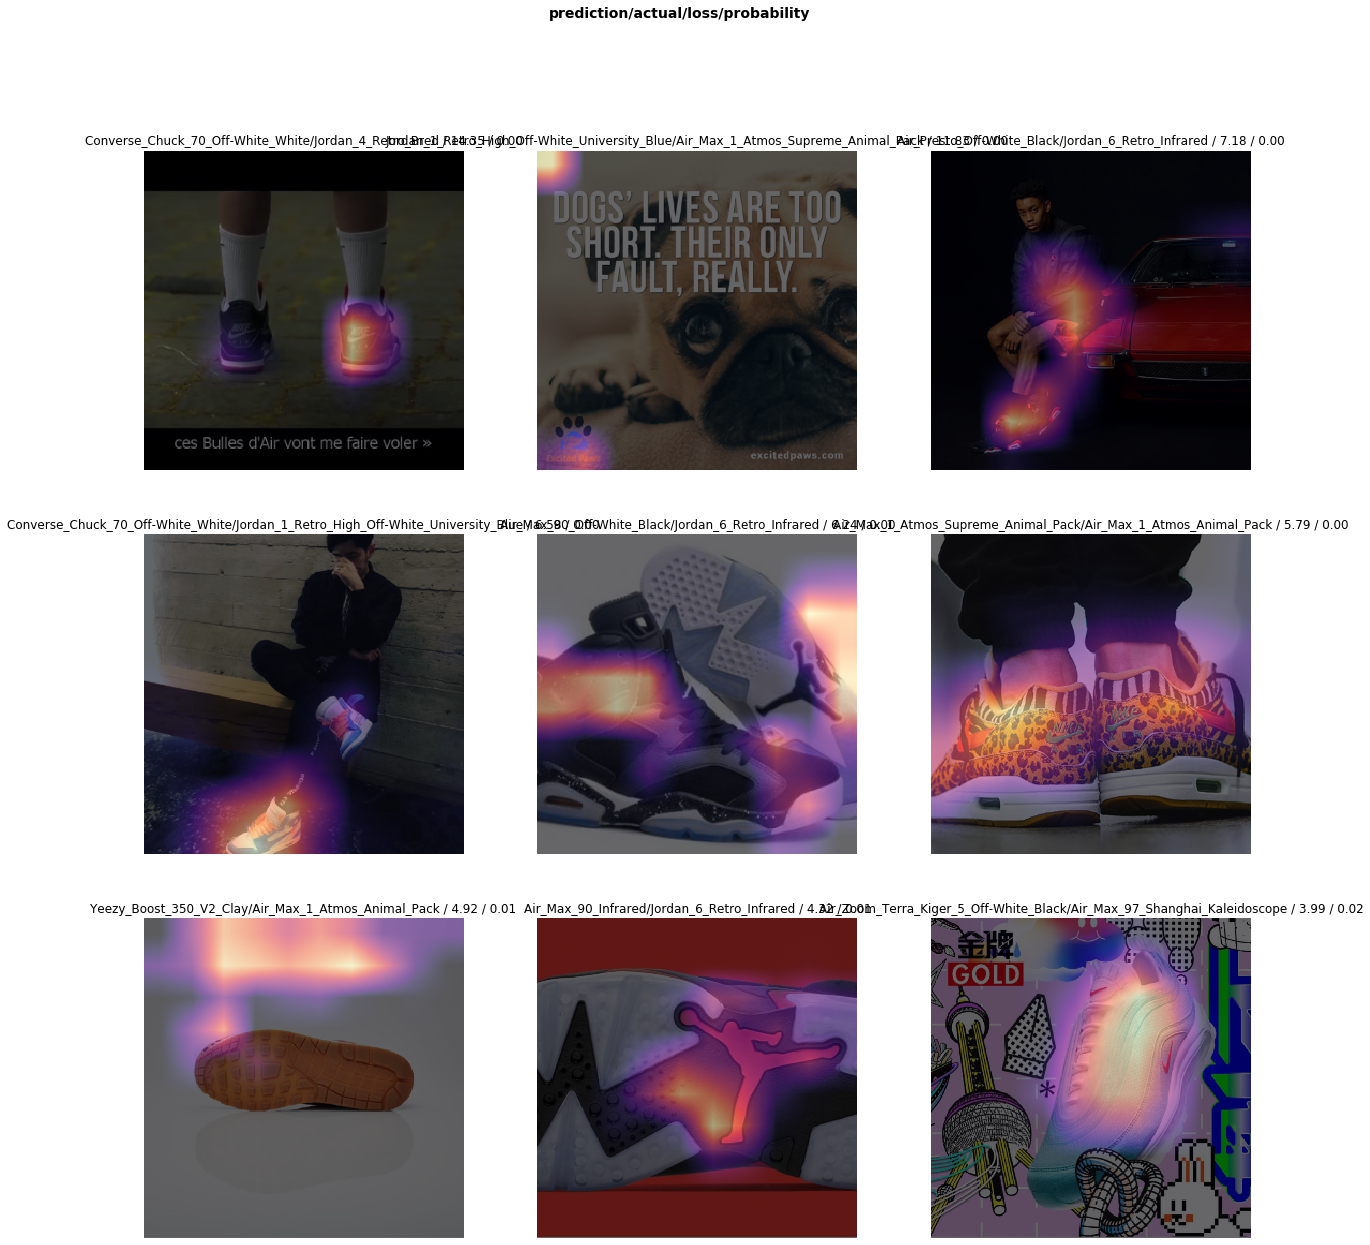

In [18]:
# Show images with the top losses
interp.plot_top_losses(9,figsize=(20,20))

In [17]:
# Export model into 'export.pkl'
learn2.export()

In [18]:
# Local testing using the instance
defaults.device = torch.device('cpu')

In [1]:
img = open_image(Path('test_images')/'jordan_ts_test.jpg')
img

NameError: name 'open_image' is not defined

In [21]:
learn = load_learner(path)

In [21]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category yeezy700_inertia

[('Yeezy700 Inertia', 0.9999951), ('Nike React 87 Orange Peel', 3.0757717e-06), ('Yeezy700 Gray', 1.4939822e-06)]


<Figure size 576x576 with 0 Axes>

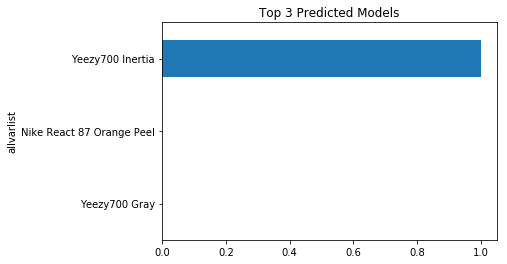

In [22]:
# Show predication bar chart for comparsion
pred = learn.predict(img)
pred_result = pred[2].sort(descending=True)
top_3_pred_probs = pred_result[0][:3]
# convert probs to numpy array because I just want the numbers by themselves without 'tensor'
top_3_pred_probs = top_3_pred_probs.numpy()

top_3_pred_class_idxs = pred_result[1][:3]

# Convert label from 'air_jordan_3' to 'Air Jordan 3' after looking up proper index
top_3_pred_classes = [learn.data.classes[i].replace('_', ' ').title() for i in top_3_pred_class_idxs]

pred_top_3_output = list(zip(top_3_pred_classes, top_3_pred_probs))
print(pred_top_3_output)

plt.figure(figsize=(8,8))
df=pd.DataFrame({'allvarlist':top_3_pred_classes,'importances': top_3_pred_probs})
df.sort_values('importances',inplace=True)
df.plot(kind='barh',y='importances',x='allvarlist', legend=False, title='Top 3 Predicted Models');

# Deploy a Lambda application for Sneaker Wizard model

Deploys a predicting application for the trained sneaker wizard model

In [22]:
import os
import io
import tarfile
import PIL
import boto3

In [23]:
# Create a clases text for pytorch model
save_texts(path/'models/classes.txt', data.classes)

In [24]:
learn.model.float()

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_s

In [25]:
# Save stage-3-101 model into a format for pytorch model application
trace_input = torch.ones(1,3,499,499).cuda()
jit_model = torch.jit.trace(learn.model.cuda(), trace_input)
model_file='sneaker_wiz_model_res101.pth'
output_path = str(path/f'models/{model_file}')
torch.jit.save(jit_model, output_path)

In [26]:
tar_file=path/'models/model.tar.gz'
classes_file='classes.txt'
with tarfile.open(tar_file, 'w:gz') as f:
    f.add(path/f'models/{model_file}', arcname=model_file)
    f.add(path/f'models/{classes_file}', arcname=classes_file)

In [27]:
s3 = boto3.resource('s3')
s3.meta.client.upload_file(str(tar_file), 'fastai-data-bucket', 'models/modelres101.tar.gz')